In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [16]:
def get_seismic_grid(segy_file_path):
    # Открываем SEGY-файл в режиме чтения
    segy = segyio.open(segy_file_path, 'r', strict=False)
    coordinate_x = segy.attributes(segyio.TraceField.SourceX)
    coordinate_y = segy.attributes(segyio.TraceField.SourceY)
    seismic_data = np.array([trace.copy() for trace in segy.trace])
    return seismic_data, np.array(coordinate_x), np.array(coordinate_y)

def plot_2d_plane(x, y, value):
    """
    Визуализация плоскости в 2D с помощью диаграммы рассеяния (scatter plot).

    Параметры:
        x (numpy.array): Массив координат по оси X.
        y (numpy.array): Массив координат по оси Y.
        value (numpy.array): Массив значений, соответствующих точкам на плоскости.
    """
    # Создание диаграммы рассеяния (scatter plot)
    plt.scatter(x, y, c=value, cmap='seismic', s=0.01)  # s - размер точек

    # Добавление цветовой шкалы (colorbar) для интерпретации значений
    cbar = plt.colorbar()
    cbar.set_label('Value')

    # Настройка осей и меток
    plt.xlabel('X')
    plt.ylabel('Y')
    #plt.title('2D Визуализация плоскости')

    # Отображение графика
    plt.show()


In [3]:
file_path = 'data/Глубинный куб NP cropped'

seismic_cube, coordinate_x, coordinate_y = get_seismic_grid(file_path)

In [4]:
mask = np.all(np.array(seismic_cube) == 0, axis=1)

missed_traces_coords = list(zip(coordinate_x[mask], coordinate_y[mask]))
missed_traces_coords

[(390625, 7515365),
 (390647, 7515376),
 (390669, 7515388),
 (390692, 7515399),
 (390714, 7515410),
 (390736, 7515421),
 (390758, 7515433),
 (390781, 7515444),
 (390803, 7515455),
 (390825, 7515466),
 (390848, 7515478),
 (390870, 7515489),
 (390892, 7515500),
 (390915, 7515512),
 (390937, 7515523),
 (390959, 7515534),
 (390982, 7515545),
 (391004, 7515557),
 (391026, 7515568),
 (391049, 7515579),
 (391071, 7515591),
 (391093, 7515602),
 (391115, 7515613),
 (391138, 7515624),
 (391160, 7515636),
 (391182, 7515647),
 (391205, 7515658),
 (391227, 7515669),
 (391249, 7515681),
 (391272, 7515692),
 (391294, 7515703),
 (391316, 7515715),
 (391339, 7515726),
 (391361, 7515737),
 (391383, 7515748),
 (391406, 7515760),
 (391428, 7515771),
 (391450, 7515782),
 (391472, 7515794),
 (391495, 7515805),
 (391517, 7515816),
 (391539, 7515827),
 (391562, 7515839),
 (391584, 7515850),
 (391606, 7515861),
 (391629, 7515873),
 (391651, 7515884),
 (391673, 7515895),
 (391696, 7515906),
 (391718, 7515918),


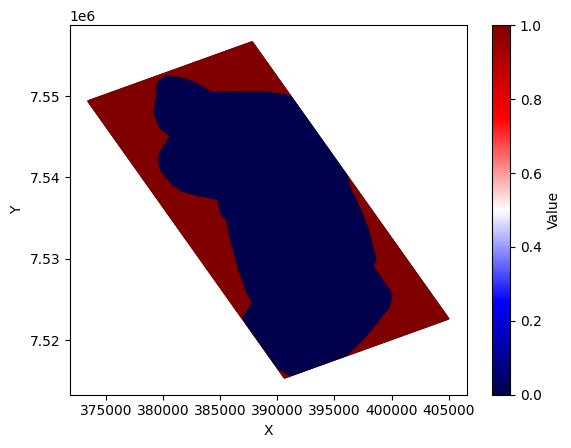

In [17]:
plot_2d_plane(coordinate_x, coordinate_y, mask)

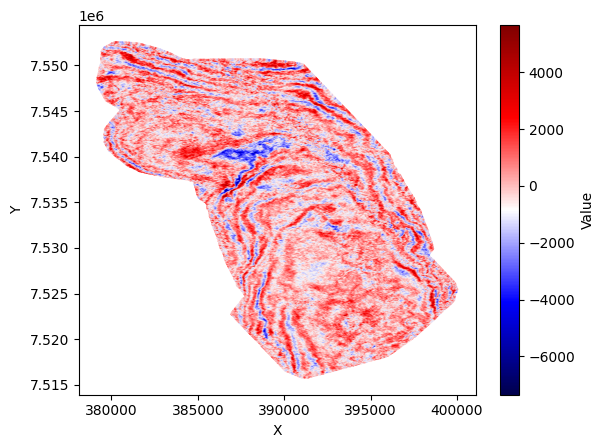

In [18]:
plot_2d_plane(coordinate_x[~mask], coordinate_y[~mask], seismic_cube[~mask][:, 0])

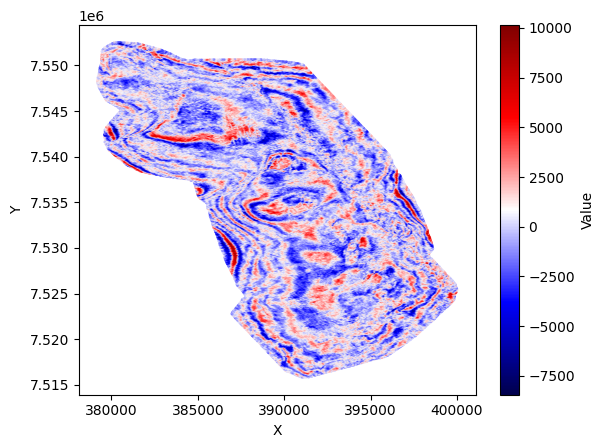

In [19]:
plot_2d_plane(coordinate_x[~mask], coordinate_y[~mask], seismic_cube[~mask][:, 117])